In [1]:
import tensorflow as tf
import keras
import numpy as np
from numpy.typing import NDArray

tf.config.list_physical_devices('GPU')

2025-03-10 01:21:42.084640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741594902.102113   25160 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741594902.107346   25160 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 01:21:42.124947: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/gkouretas/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
data: NDArray = np.load("training_datasets.npy", allow_pickle=True)
labels: NDArray = np.load("training_labels.npy", allow_pickle=True)

In [3]:
data.shape, labels.shape

((34, 6, 4), (34, 6))

In [4]:
SAMPLING_RATE_EMG = 1. / 1000
SAMPLING_RATE_BPM = 1. / 200
SAMPLING_RATE_IMU = 1. / 100

In [5]:
%matplotlib qt
import matplotlib.pyplot as plt

signals = ("EMG", "HR", "Accelerometer", "Gyroscope", "Fatigue")
sampling_rates = (SAMPLING_RATE_EMG, SAMPLING_RATE_BPM, SAMPLING_RATE_IMU, SAMPLING_RATE_IMU, SAMPLING_RATE_EMG)

n_images = 2
fig, ax = plt.subplots(len(signals), n_images, sharex=True, figsize=(16,9))

for i in range(n_images):
    subject = np.random.randint(0, data.shape[0])
    trial = np.random.randint(0, data.shape[1])

    ax[0][i].set_title(f"Subject {subject}, trial {trial}")

    for j in range(len(signals)):
        if j == len(signals)-1:
            signal: NDArray = labels[subject][trial]
        else:
            signal: NDArray = data[subject][trial][j]

        print(signal.shape, sampling_rates[j]*signal.size)

        ax[j][i].plot(
            np.linspace(0.0, sampling_rates[j]*signal.size, signal.size), 
            signal
        )

        ax[j][i].set_ylabel(signals[j])

(51630,) 51.63
(10325,) 51.625
(5163,) 51.63
(5163,) 51.63
(50000,) 50.0
(72840,) 72.84
(14567,) 72.83500000000001
(7284,) 72.84
(7284,) 72.84
(72000,) 72.0


In [6]:
from enum import IntEnum, auto

class FatigueClassifierConstructor:
    class FatigueInputs(IntEnum):
        EMG = auto()
        HR = auto()
        ACCEL = auto()
        GYRO = auto()

    @classmethod
    def preprocess_signal(self, signal: NDArray, fs: float, window_size: float, stride: float, max_duration_sec: float, pad_value: float = 0.0):
        _size = int(fs*max_duration_sec)
        _window = int(fs*window_size)
        _stride = int(fs*stride)

        _output_signal = np.zeros((signal.shape[0], int((_size-_window)/_stride), _window))
        
        for i in range(signal.shape[0]):
            for j, k in enumerate(range(0, _size-_window, _stride)):
                if k >= signal[i].size:
                    _output_signal[i][j] = np.ones(shape = (1, _window)) * pad_value
                elif k+_window >= signal[i].size:
                    _output_signal[i][j] = np.concatenate(
                        [np.array(signal[i][k:signal[i].size]).reshape((1, signal[i][k:signal[i].size].size)), np.ones(shape = (1, _window-(signal[i].size-k))) * pad_value],
                        axis = 1
                    )
                else:
                    _output_signal[i][j] = signal[i][k:k+_window]

        return _output_signal
    
    @classmethod
    def preprocess_labels(self, labels: NDArray, fs: float, window_size: float, stride: float, max_duration_sec: float, pad_value: float = 0.0):
        _size = int(fs*max_duration_sec)
        _window = int(fs*window_size)
        _stride = int(fs*stride)

        _output_signal = np.zeros((labels.shape[0], int((_size-_window)/_stride)))
        for i in range(labels.shape[0]):
            for j, k in enumerate(range(0, _size-_window, _stride)):
                if k+_window >= labels[i].size:
                    _output_signal[i][j] = pad_value
                else:
                    _output_signal[i][j] = labels[i][k+_window]

        return _output_signal

    def __init__(self, mask_value: float | None = None):
        self._inputs: list[keras.layers.InputLayer] = []
        self._mask: list[keras.layers.Masking] = []
        self._lstm: list[keras.layers.LSTM] = []
        self._classifier: list[keras.layers.Dense] = []
        self._scale: list[keras.layers.Lambda] = []

        self._weight_sum: float = 0.0
        self._mask_value = mask_value

    def add_lstm_block(self, weight: float, name_suffix: str = None, input_kwargs: dict = {}, lstm_kwargs: dict = {}):
        self._inputs.append(
            keras.layers.Input(
                name = f"input_{len(self._inputs)}" + ("" if name_suffix is None else f"_{name_suffix}"), 
                **input_kwargs
            )
        )

        if self._mask_value is not None:
            self._mask.append(
                keras.layers.Masking(mask_value=self._mask_value)(self._inputs[-1])
            )

            # LSTM for prediction
            self._lstm.append(
                keras.layers.LSTM(
                    name = f"lstm_{len(self._inputs)}" + ("" if name_suffix is None else f"_{name_suffix}"), 
                    **lstm_kwargs
                )(self._mask[-1])
            )
        else:
            # LSTM for prediction
            self._lstm.append(
                keras.layers.LSTM(
                    name = f"lstm_{len(self._inputs)}" + ("" if name_suffix is None else f"_{name_suffix}"), 
                    **lstm_kwargs
                )(self._inputs[-1])
            )

        # Softmax + weight in order to perform a weighted sum
        self._classifier.append(
            keras.layers.Dense(
                1,
                activation="sigmoid",
                name=f"classification_{len(self._inputs)}_layer" + ("" if name_suffix is None else f"_{name_suffix}"), 
            )(self._lstm[-1])
        )

        self._scale.append(
            keras.layers.Lambda(
                lambda x: x * weight, 
                name=f"scale_factor_{weight}_{len(self._inputs)}_layer" + ("" if name_suffix is None else f"_{name_suffix}")
            )(self._classifier[-1])
        )

        self._weight_sum += weight

    def masked_loss_with_all_zero_check(self, y_true, y_pred):
        # Create a mask where values are not equal to the mask_value (e.g., 0.0)
        mask = tf.cast(tf.not_equal(y_true, self._mask_value), keras.backend.floatx())  # 1 for unmasked values, 0 for masked
        # Check if all values are masked (i.e., mask is all zeros)
        all_masked = tf.reduce_all(mask == self._mask_value, axis=-1)  # True if entire sequence is masked
        # If the sequence is all masked, ignore it by returning 0 loss for this sequence
        loss = keras.losses.mean_squared_error(y_true, y_pred)
        masked_loss = loss * mask  # Apply mask to loss
        print(all_masked[0])
        return loss
        # Use K.switch to set loss to 0 for all-masked sequences
        #return tf.switch_case(all_masked, 0.0, tf.reduce_sum(masked_loss) / tf.reduce_sum(mask))  # Normalize by number of valid values

    def init(self) -> keras.models.Model:
        assert np.sum(self._weight_sum) == 1.0, "Weights must sum to 1"
        print(self._inputs, self._lstm)
        return keras.models.Model(inputs=self._inputs, outputs=keras.layers.Add()(self._scale))


In [7]:
data.shape

(34, 6, 4)

In [8]:
combined_data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
combined_data.shape

(204, 4)

In [9]:
labels.shape

(34, 6)

In [10]:
combined_labels = labels.reshape((labels.shape[0]*labels.shape[1],))
combined_labels.shape

(204,)

In [11]:
mask_value = -10.
inputs = {}
for i, Ts in enumerate(sampling_rates[:-1]):
    inputs[signals[i]] = FatigueClassifierConstructor.preprocess_signal(combined_data[..., i], fs=1/Ts, window_size=5, stride=1, max_duration_sec=240, pad_value=mask_value)
    print(inputs[signals[i]].shape)

outputs = FatigueClassifierConstructor.preprocess_labels(combined_labels, fs=1000, window_size=5, stride=1, max_duration_sec=240, pad_value=mask_value)
outputs.shape

(204, 235, 5000)
(204, 235, 1000)
(204, 235, 500)
(204, 235, 500)


(204, 235)

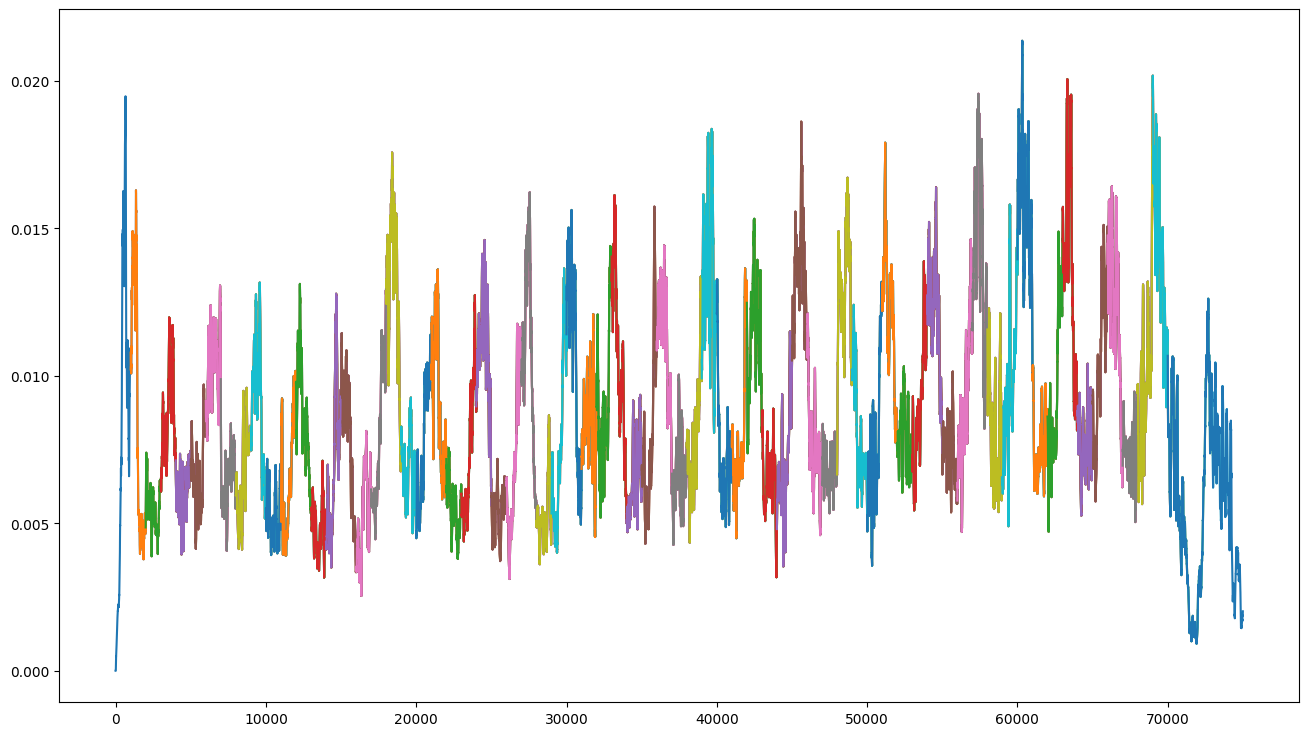

In [12]:
%matplotlib inline
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
i = 0
window = 5000
stride = 1000

for signal in inputs["EMG"][0]:
    if mask_value in signal: continue
    else:
        ax.plot(np.arange(i, i+window), signal)
        i += stride

In [13]:
fatigue_classifier = FatigueClassifierConstructor(mask_value=mask_value)

for k, v in inputs.items():
    if k == "EMG": weight = 0.5
    elif k == "HR": weight = 0.25
    elif k == "Accelerometer": weight = 0.125
    elif k == "Gyroscope": weight = 0.125
    else: raise NotImplementedError(f"Invalid key: {k}")

    fatigue_classifier.add_lstm_block(weight, name_suffix=k, input_kwargs={"shape": v.shape[1:]}, lstm_kwargs={"units": 128, "return_sequences": True})

model = fatigue_classifier.init()
model.summary()

I0000 00:00:1741594908.623118   25160 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4915 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:02:00.0, compute capability: 6.1


[<KerasTensor shape=(None, 235, 5000), dtype=float32, sparse=False, ragged=False, name=input_0_EMG>, <KerasTensor shape=(None, 235, 1000), dtype=float32, sparse=False, ragged=False, name=input_1_HR>, <KerasTensor shape=(None, 235, 500), dtype=float32, sparse=False, ragged=False, name=input_2_Accelerometer>, <KerasTensor shape=(None, 235, 500), dtype=float32, sparse=False, ragged=False, name=input_3_Gyroscope>] [<KerasTensor shape=(None, 235, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_3>, <KerasTensor shape=(None, 235, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_11>, <KerasTensor shape=(None, 235, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_19>, <KerasTensor shape=(None, 235, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_27>]


/home/gkouretas/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'scale_factor_0.5_1_layer_EMG' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/gkouretas/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'scale_factor_0.25_2_layer_HR' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/gkouretas/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'scale_factor_0.125_3_layer_Accelerometer' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask informati

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_0_EMG         │ (None, 235, 5000) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_1_HR          │ (None, 235, 1000) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2_Accelerome… │ (None, 235, 500)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_3_Gyroscope   │ (None, 235, 500)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 235, 5000) │          0 │ input_0_EMG[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 235, 1000) │          0 │ input_1_HR[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 235, 500)  │          0 │ input_2_Accelero… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 235, 500)  │          0 │ input_3_Gyroscop… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 235, 5000) │          0 │ input_0_EMG[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 235)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_1 (Masking) │ (None, 235, 1000) │          0 │ input_1_HR[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_1 (Any)         │ (None, 235)       │          0 │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_2 (Masking) │ (None, 235, 500)  │          0 │ input_2_Accelero… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_2 (Any)         │ (None, 235)       │          0 │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_3 (Masking) │ (None, 235, 500)  │          0 │ input_3_Gyroscop… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_3 (Any)         │ (None, 235)       │          0 │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1_EMG (LSTM)   │ (None, 235, 128)  │  2,626,048 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2_HR (LSTM)    │ (None, 235, 128)  │    578,048 │ masking_1[0][0],  │
│                     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3_Acceleromet… │ (None, 235, 128)  │    322,048 │ masking_2[0][0],  │
│ (LSTM)              │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,848,708 (14.68 MB)

 Trainable params: 3,848,708 (14.68 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
optimizer = keras.optimizers.Adam()
fatigue_classifier
# model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError, metrics=["accuracy", "mse"])
model.compile(optimizer=optimizer, loss=fatigue_classifier.masked_loss_with_all_zero_check, metrics=["mse"])

In [15]:
history = model.fit(
    (
        tf.convert_to_tensor(inputs["EMG"], dtype="float32"), 
        tf.convert_to_tensor(inputs["HR"], dtype="float32"), 
        tf.convert_to_tensor(inputs["Accelerometer"], dtype="float32"), 
        tf.convert_to_tensor(inputs["Gyroscope"], dtype="float32")
    ),
     tf.convert_to_tensor(outputs, dtype="float32"),
     batch_size=1,
     epochs=50,
     validation_split=0.8
)

Epoch 1/50
Tensor("compile_loss/masked_loss_with_all_zero_check/All:0", shape=(1,), dtype=bool)
Tensor("compile_loss/masked_loss_with_all_zero_check/All:0", shape=(1,), dtype=bool)


I0000 00:00:1741594916.140383   25236 cuda_dnn.cc:529] Loaded cuDNN version 90300


37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 75.8047 - mse: 75.8047Tensor("compile_loss/masked_loss_with_all_zero_check/All:0", shape=(1,), dtype=bool)
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 75.7514 - mse: 75.7514 - val_loss: 79.5985 - val_mse: 79.5985
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 75.2233 - mse: 75.2233 - val_loss: 79.4565 - val_mse: 79.4565
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 73.0981 - mse: 73.0981 - val_loss: 79.3227 - val_mse: 79.3227
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 78.1460 - mse: 78.1460 - val_loss: 79.1685 - val_mse: 79.1685
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 76.2767 - mse: 76.2767 - val_loss: 79.0301 - val_mse: 79.0301
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 74.7962 - mse: 74.7962 - val_loss: 78.8967 - val_mse: 78.8967
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 77.1243 - mse: 77.1243 - val_loss: 78.7550 - val_mse: 78.7550
Epoch 8/5

KeyboardInterrupt: 

In [70]:
out = model.predict(
    (
        tf.convert_to_tensor(inputs["EMG"][0].reshape([1] + list(inputs["EMG"][0].shape)), dtype="float32"), 
        tf.convert_to_tensor(inputs["HR"][0].reshape([1] + list(inputs["HR"][0].shape)), dtype="float32"), 
        tf.convert_to_tensor(inputs["Accelerometer"][0].reshape([1] + list(inputs["Accelerometer"][0].shape)), dtype="float32"), 
        tf.convert_to_tensor(inputs["Gyroscope"][0].reshape([1] + list(inputs["Gyroscope"][0].shape)), dtype="float32")
    ),
    batch_size=1
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


In [71]:
%matplotlib qt
plt.plot(out[0, :, 0])
plt.plot(outputs[0])

In [47]:
out

array([[[2.1467637e-01],
        [1.9010970e-01],
        [1.9126336e-01],
        [1.9924769e-01],
        [2.4119510e-01],
        [2.6962426e-01],
        [2.9875430e-01],
        [3.5892981e-01],
        [3.8985109e-01],
        [4.2708692e-01],
        [4.7216177e-01],
        [4.7713634e-01],
        [4.9489722e-01],
        [5.1400417e-01],
        [5.1354945e-01],
        [5.1581371e-01],
        [5.0810403e-01],
        [4.5619014e-01],
        [4.2540994e-01],
        [4.2595470e-01],
        [4.1546023e-01],
        [4.2235819e-01],
        [4.3565169e-01],
        [4.2700148e-01],
        [4.5786890e-01],
        [5.2372813e-01],
        [5.2903020e-01],
        [5.4305232e-01],
        [5.5528373e-01],
        [5.3799498e-01],
        [5.3524113e-01],
        [5.4120326e-01],
        [5.2948993e-01],
        [5.3286928e-01],
        [5.4431486e-01],
        [5.3118187e-01],
        [5.2404451e-01],
        [5.2812129e-01],
        [4.9874893e-01],
        [4.7349066e-01],


In [51]:
outputs[0].shape, out.shape

((235,), (1, 235, 1))

In [52]:
outputs[0] - out[0, :, 0]

array([-8.52104851e-02, -3.92508061e-02, -2.10115306e-02, -1.18172880e-02,
       -3.90147950e-02, -5.53370182e-02, -7.47529240e-02, -1.26928564e-01,
       -1.51135653e-01, -1.82514377e-01, -2.22160622e-01, -2.21706499e-01,
       -2.33609993e-01, -2.46002297e-01, -2.37547062e-01, -2.30096361e-01,
       -2.09249404e-01, -1.39955533e-01, -8.84526835e-02, -6.58321556e-02,
       -3.06298078e-02, -1.21773327e-02, -3.77890636e-04,  3.22077465e-02,
        2.32181810e-02, -2.37207854e-02, -1.26804381e-02, -1.17314472e-02,
       -1.00201979e-02,  2.05256331e-02,  3.61938731e-02,  4.31462973e-02,
        6.81172241e-02,  7.86813952e-02,  8.22081162e-02,  1.11685068e-01,
        1.37746095e-01,  1.55549685e-01,  2.08859080e-01,  2.59211007e-01,
        2.90578632e-01,  3.50469442e-01,  3.96914129e-01,  4.07481818e-01,
        4.40238778e-01,  4.71093670e-01,  4.58966375e-01,  4.66142951e-01,
        4.42970152e-01,  3.85093010e-01,  3.92026711e-01,  4.01851881e-01,
        3.90904121e-01,  